# 1D Problem

In [1]:
import oommfc as oc
import discretisedfield as df
import numpy as np
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
L = 100e-9 # sample length in nm

mesh = oc.Mesh(p1=(-L/2, 0, 0), p2=(L/2, 5e-9, 5e-9), cell=(5e-9, 5e-9, 5e-9))

In [3]:
system = oc.System(name="helix")

system.hamiltonian = oc.Exchange(A=8.78e-12) + oc.DMI(D=1.58e-3, kind='bulk') + \
                     oc.UniaxialAnisotropy(K1=0.51e6, u=(0, 0, 1))  # + oc.Demag()

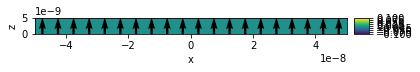

In [4]:
Ms = 1.1e6
m_init = (0, 0, 1)

system.m = df.Field(mesh, value=m_init, norm=Ms)

system.m.plot_plane('y')

2017/11/1 10:48: Calling OOMMF (helix/helix.mif) ... [0.5s]


/usr/local/lib/python3.5/dist-packages/oommfodt/oommfodt.py:114: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.units = dict(zip(columns, units))


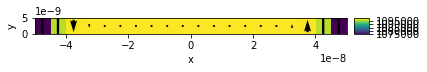

In [5]:
md = oc.MinDriver()
md.drive(system)

system.m.plot_plane('z')

In [6]:
# extract magnetization data
nx, ny, nz = mesh.n 
all_mesh_data = list(system.m.line(p1=(-L/2 + 2.5e-9, 0, 0), p2=(L/2 - 2.5e-9, 0, 0), n=nx)) # list with data along x-axis
coordinates, magnetization  = list(zip(*all_mesh_data))

x, y, z = list(zip(*coordinates))
mx, my, mz = list(zip(*magnetization))
mx_norm = np.array(mx)/Ms
my_norm = np.array(my)/Ms
mz_norm = np.array(mz)/Ms

In [7]:
A = system.hamiltonian.exchange.A
D = system.hamiltonian.dmi.D
K = system.hamiltonian.uniaxialanisotropy.K1
delta = np.sqrt(A/K)
xi = 2*A/D

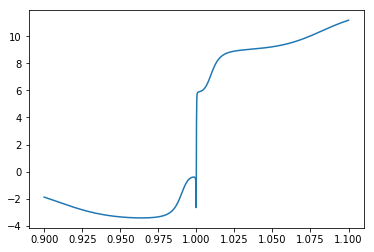

In [8]:
def ode_1d(theta, r):
    return np.array([theta[1], np.cos(theta[0])*np.sin(theta[0])/delta**2])


def residual(dthetadr_guess):
    '''
    function to calculate the residual, which is the difference of the given solution at 1/xi at r = R
    to the result, which is obtained by solving the ODE as initial value problem with theta(0) = -np.sqrt(A/K)/xi and 
    theta'(0) = dthetadr_guess
    '''
    # if the derivative is divided by xi the solver seems to work properly
    solution = scipy.integrate.odeint(ode_1d, np.array([np.arcsin(-delta/xi), dthetadr_guess/xi]), r_array) 
    return solution[-1,0] - np.arcsin(delta/xi)

# vector on which the ODE is supposed to be solved
r_array = np.linspace(-L/2, L/2, 300)

# upper and lower boundaries of interval from which dthetadr_guess is guessed
dthetadr_left = 0.9
dthetadr_right = 1.1

dthetadr_guess_range = np.linspace(dthetadr_left, dthetadr_right, 1000)

# array for all calculated residuals
residuals = []
for dthetadr_guess in dthetadr_guess_range:
    residuals.append(residual(dthetadr_guess))

plt.figure()
plt.plot(dthetadr_guess_range, residuals)


In [9]:
# find the root of the residual function, i.e. the zero crossing, use the scipy.brentq method for this purpose
dthetadr_0 = scipy.optimize.brentq(residual, dthetadr_left, dthetadr_right)
# plug the found solution for the missing boundary condition into the ODE solver
final_solution = scipy.integrate.odeint(ode_1d, np.array([np.arcsin(-delta/xi), dthetadr_0/xi]), r_array)

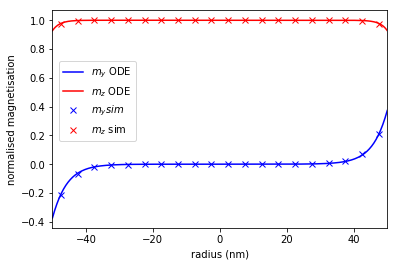

In [10]:
plt.figure()
plt.plot(r_array/1e-9, np.sin(final_solution[:, 0]), 'b', label=r'$m_y$ ODE')
plt.plot(r_array/1e-9, np.cos(final_solution[:, 0]), 'r', label=r'$m_z$ ODE')
# plt.plot(np.array(x)/1e-9, mx_norm, 'gx', label=r'$m_x$ sim')
plt.plot(np.array(x)/1e-9, my_norm, 'bx', label=r'$m_y sim$')
plt.plot(np.array(x)/1e-9, mz_norm, 'rx', label=r'$m_z$ sim')
plt.xlim([-L/(2*1e-9), L/(2*1e-9)])
#plt.ylim([-0.7, 1.2])
plt.xlabel('radius (nm)')
plt.ylabel('normalised magnetisation')
plt.legend(loc=(0.02,0.4))
plt.savefig('figures/result_1d.pdf', dpi=300)

## Helix

2017/11/1 13:51: Calling OOMMF (onedhelix/onedhelix.mif) ... [0.9s]


/usr/local/lib/python3.5/dist-packages/oommfodt/oommfodt.py:114: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.units = dict(zip(columns, units))


(-1.75e-07, 1.75e-07)

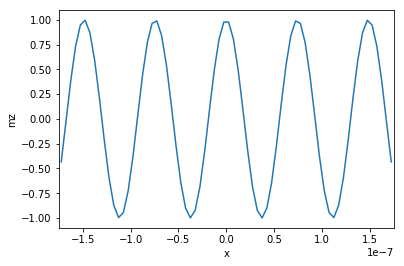

In [19]:
L = 350e-9 # sample length in nm

mesh = oc.Mesh(p1=(-L/2, 0, 0), p2=(L/2, 5e-9, 5e-9), cell=(5e-9, 5e-9, 5e-9))

system = oc.System(name="onedhelix")

system.hamiltonian = oc.Exchange(A=8.78e-12) + oc.DMI(D=1.58e-3, kind='bulk')

system.m = df.Field(mesh, value=(0, 0, 1))

md = oc.MinDriver()
md.drive(system)

x = []
mz = []
for coord in mesh.coordinates:
    x.append(coord[0])
    mz.append(system.m(coord)[2])
    
plt.plot(x, mz)
plt.xlabel("x")
plt.ylabel("mz")
plt.xlim(-175e-9, 175e-9)  # Fourier (paper discussion)